In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns

In [2]:
# Load the dataset, skip the first row as it contains headers within the data
data = pd.read_csv('acs.csv')

In [3]:
data.drop('birth_qrtr', axis=1, inplace=True)
data = data[data['income'] != 0]

In [4]:
# Convert age to numeric
data['age'] = pd.to_numeric(data['age'], errors='coerce')


In [5]:
# Handle categorical variables: race, gender, citizen, lang, married, edu, disability
categorical_cols = ['race', 'gender', 'citizen', 'lang', 'married', 'edu', 'disability', 'employment']

In [6]:
# Apply one-hot encoding to categorical variables
for col in categorical_cols: 
    encoded_cols = pd.get_dummies(data[col], prefix=col)
    data = data.drop(columns=[col])
    data = pd.concat([data, encoded_cols], axis=1)


In [7]:
data.dropna(subset=['income'], inplace=True)
data = data[data['income'] <= 100000]

In [8]:
# Split the data into train, dev, and test sets
df_train, df_test = train_test_split(data, test_size=0.2, random_state=42)
df_train, df_dev = train_test_split(df_train, test_size=0.25, random_state=99)

In [9]:
# Separate target values
x_train = df_train.drop(['income'], axis=1)
y_train = pd.DataFrame(data=df_train['income'], columns=["income"])

x_dev = df_dev.drop(['income'], axis=1)
y_dev = pd.DataFrame(data=df_dev['income'], columns=["income"])

x_test = df_test.drop(['income'], axis=1)
y_test = pd.DataFrame(data=df_test['income'], columns=["income"])

In [10]:
# Calculate correlation coefficients
correlations = x_train.corrwith(y_train['income'])
print("Correlation coefficients:")
print(correlations)


Correlation coefficients:
hrs_work                         0.491282
age                              0.260716
time_to_work                     0.150834
race_asian                       0.015394
race_black                      -0.089473
race_other                      -0.083717
race_white                       0.112120
gender_female                   -0.220248
gender_male                      0.220248
citizen_no                      -0.060591
citizen_yes                      0.060591
lang_english                     0.073243
lang_other                      -0.073243
married_no                      -0.266902
married_yes                      0.266902
edu_college                      0.231816
edu_grad                         0.216887
edu_hs or lower                 -0.343859
disability_no                    0.117762
disability_yes                  -0.117762
employment_employed              0.314293
employment_not in labor force   -0.203471
employment_unemployed           -0.227475
dtype: f

In [11]:
# Set a threshold for significance
threshold = 0.01

# Drop variables not significantly correlated with income
significant_variables = correlations[abs(correlations) > threshold]
removed_variables = correlations[abs(correlations) <= threshold]

x_train = x_train[significant_variables.index]
x_dev = x_dev[significant_variables.index]
x_test = x_test[significant_variables.index]

In [12]:
print("\nVariables removed due to the filter:")
for col, correlation in removed_variables.items():  # New loop to print removed variables
    print(col, ":", correlation)

print("\nRemaining variables and number of null values:")
for col in x_train.columns:
    null_values = np.sum(x_train[col].isnull())
    print(col, ":", null_values)



Variables removed due to the filter:

Remaining variables and number of null values:
hrs_work : 0
age : 0
time_to_work : 80
race_asian : 0
race_black : 0
race_other : 0
race_white : 0
gender_female : 0
gender_male : 0
citizen_no : 0
citizen_yes : 0
lang_english : 0
lang_other : 0
married_no : 0
married_yes : 0
edu_college : 0
edu_grad : 0
edu_hs or lower : 0
disability_no : 0
disability_yes : 0
employment_employed : 0
employment_not in labor force : 0
employment_unemployed : 0


In [13]:
#We can see that time_to_work still has some null values
#We do not want to drop this variable, however, because it is shown to be highly correlated with income.
#Instead, we can drop the instances where it is null.

x_train = x_train.dropna(subset=['time_to_work'])
y_train = y_train.loc[x_train.index]

x_dev = x_dev.dropna(subset=['time_to_work'])
y_dev = y_dev.loc[x_dev.index]

x_test = x_test.dropna(subset=['time_to_work'])
y_test = y_test.loc[x_test.index]

# Check remaining null values
print("Remaining null values in training set:")
print(x_train.isnull().sum())

print("Remaining null values in development set:")
print(x_dev.isnull().sum())

print("Remaining null values in test set:")
print(x_test.isnull().sum())

Remaining null values in training set:
hrs_work                         0
age                              0
time_to_work                     0
race_asian                       0
race_black                       0
race_other                       0
race_white                       0
gender_female                    0
gender_male                      0
citizen_no                       0
citizen_yes                      0
lang_english                     0
lang_other                       0
married_no                       0
married_yes                      0
edu_college                      0
edu_grad                         0
edu_hs or lower                  0
disability_no                    0
disability_yes                   0
employment_employed              0
employment_not in labor force    0
employment_unemployed            0
dtype: int64
Remaining null values in development set:
hrs_work                         0
age                              0
time_to_work                   

In [14]:
income_threshold = 100000

# Filter out rows where income is greater than the threshold
high_income_rows_train = y_train['income'] > income_threshold
high_income_rows_dev = y_dev['income'] > income_threshold
high_income_rows_test = y_test['income'] > income_threshold

# Drop rows where income is greater than the threshold
x_train = x_train[~high_income_rows_train]
y_train = y_train.loc[~high_income_rows_train]

x_dev = x_dev[~high_income_rows_dev]
y_dev = y_dev.loc[~high_income_rows_dev]

x_test = x_test[~high_income_rows_test]
y_test = y_test.loc[~high_income_rows_test]

# Check the shape of the datasets after dropping rows
print("Shape of training set after dropping high-income instances:", x_train.shape)
print("Shape of development set after dropping high-income instances:", x_dev.shape)
print("Shape of test set after dropping high-income instances:", x_test.shape)

Shape of training set after dropping high-income instances: (417, 23)
Shape of development set after dropping high-income instances: (132, 23)
Shape of test set after dropping high-income instances: (137, 23)


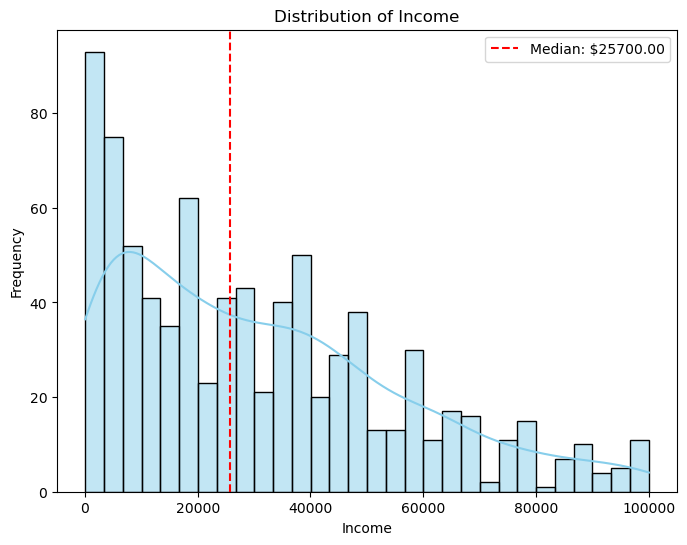

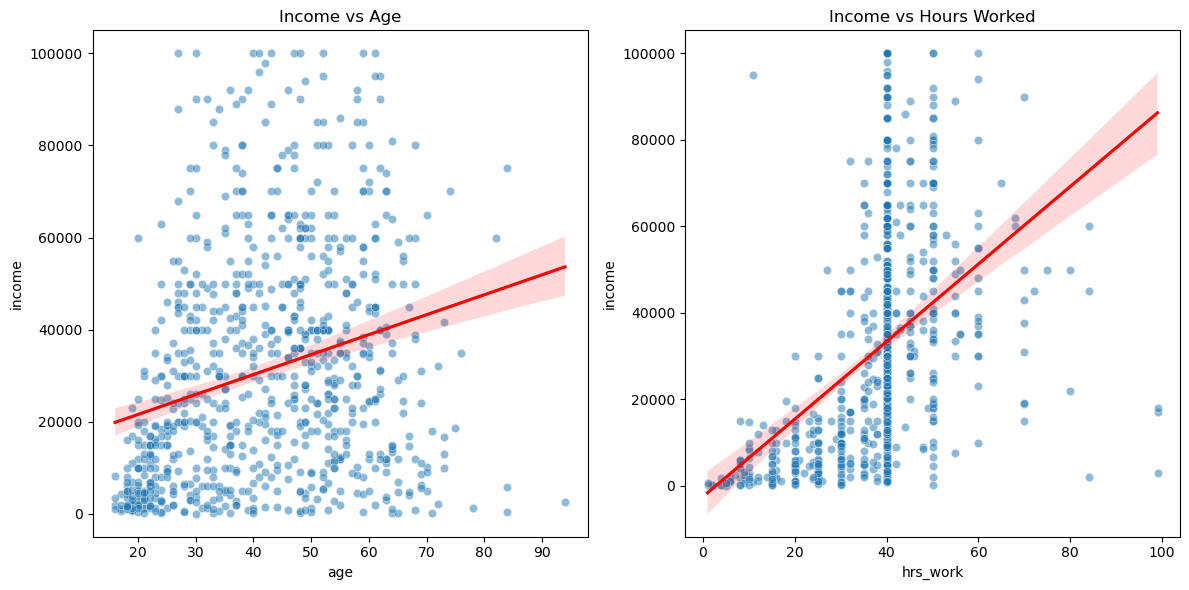

In [15]:
# Visualization of the response variable (income) using a histogram
plt.figure(figsize=(8, 6))
sns.histplot(data['income'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Income')
plt.xlabel('Income')
plt.ylabel('Frequency')

median_income = data['income'].median()
plt.axvline(median_income, color='red', linestyle='--', label=f'Median: ${median_income:.2f}')
plt.legend()

plt.show()

# Visualization of key predictors (age and hours worked) against the response variable (income)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(x='age', y='income', data=data, alpha=0.5)
plt.title('Income vs Age')
plt.xlabel('Age')
plt.ylabel('Income')
sns.regplot(x='age', y='income', data=data, scatter=False, color='red')

plt.subplot(1, 2, 2)
sns.scatterplot(x='hrs_work', y='income', data=data, alpha=0.5)
plt.title('Income vs Hours Worked')
plt.xlabel('Hours Worked')
plt.ylabel('Income')
sns.regplot(x='hrs_work', y='income', data=data, scatter=False, color='red')

plt.tight_layout()
plt.show()


Mean Squared Error: 436099888.03847086
R-squared: 0.4118690590015899


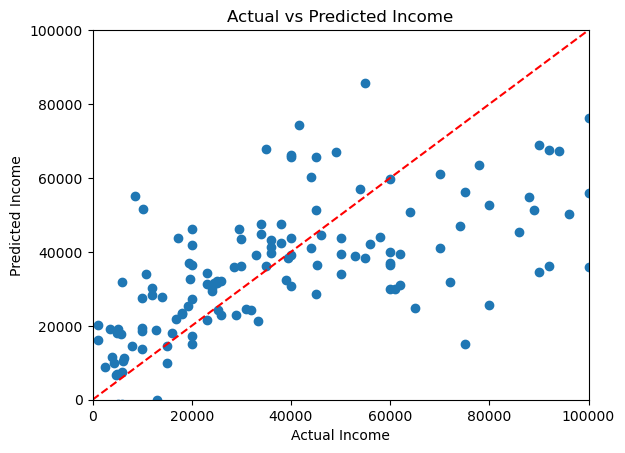

In [16]:
# Instantiate the model
model = LinearRegression()

# Fit the model to the training data
model.fit(x_train, y_train)

# Make predictions on the test data
predictions = model.predict(x_test)

# Evaluate the model performance
mse = mean_squared_error(y_test, predictions)
r_squared = r2_score(y_test, predictions)
print("\nMean Squared Error:", mse)
print("R-squared:", r_squared)

# Plot the results
plt.scatter(y_test, predictions)
plt.xlim(0, 100000)  # Limit x-axis to income values <= 150,000
plt.ylim(0, 100000)  # Limit y-axis to predicted income values <= 150,000
plt.plot([0, 100000], [0, 100000], '--', color='red')  # Diagonal line
plt.xlabel('Actual Income')
plt.ylabel('Predicted Income')
plt.title('Actual vs Predicted Income')
plt.show()